## 0. Introduction 

The aim of this lab is to get familiar with **regression problems**, the concepts of **under/over-fitting**, and **regularization**. 


1.   This lab is the first course-work activity **Assignment 1 part 1: Regression (10%)**
2. The Assignment is due on **Friday , 28th October, 11:59pm**
2.   A report answering the <font color = 'red'>**questions in</font><font color = "maroon"> red**</font> should be submitted on QMplus along with the completed Notebook.
3. The report should be a separate file in **pdf format** (so **NOT** *doc, docx, notebook* etc.), well identified with your name, student number, assignment number (for instance, Assignment 1), module code.
4. Make sure that **any figures or code** you comment on, are **included in the report**.
5. No other means of submission other than the appropriate QM+ link is acceptable at any time (so NO email attachments, etc.)
6. **PLAGIARISM** <ins>is an irreversible non-negotiable failure in the course</ins> (if in doubt of what constitutes plagiarism, ask!). 


For this lab we will use the [diabetes](https://www4.stat.ncsu.edu/~boos/var.select/diabetes.html) dataset.

In [1]:
import torch
from torch import nn
from sklearn import model_selection
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from IPython import display

import typing
%matplotlib inline

In [2]:
diabetes_db = pd.read_csv('https://www4.stat.ncsu.edu/~boos/var.select/diabetes.tab.txt', sep='\t', header=0)
sn.pairplot(diabetes_db)

In [3]:
diabetes_db.head(10)

,AGE,SEX,BMI,BP,S1,S2,S3,S4,S5,S6,Y
0,59,2,32.1,101.0,157,93.2,38.0,4.00,4.8598,87,151
1,48,1,21.6,87.0,183,103.2,70.0,3.00,3.8918,69,75
2,72,2,30.5,93.0,156,93.6,41.0,4.00,4.6728,85,141
3,24,1,25.3,84.0,198,131.4,40.0,5.00,4.8903,89,206
4,50,1,23.0,101.0,192,125.4,52.0,4.00,4.2905,80,135
5,23,1,22.6,89.0,139,64.8,61.0,2.00,4.1897,68,97
6,36,2,22.0,90.0,160,99.6,50.0,3.00,3.9512,82,138
7,66,2,26.2,114.0,255,185.0,56.0,4.55,4.2485,92,63
8,60,2,32.1,83.0,179,119.4,42.0,4.00,4.4773,94,110
9,29,1,30.0,85.0,180,93.4,43.0,4.00,5.3845,88,310


We first split the data into test and training sets. For consistency and to allow for meaningful comparison the same splits are maintained in the remainder of the lab.

In [3]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    diabetes_db.loc[:, diabetes_db.columns != 'Y'],
    diabetes_db['Y'],
    test_size=0.2,
    random_state=42
    )

x_train = torch.from_numpy(X_train.values).float()
x_test = torch.from_numpy(X_test.values).float()

y_train = torch.from_numpy(y_train.values).float()
y_train = y_train.reshape(-1, 1)

y_test = torch.from_numpy(y_test.values).float()
y_test = y_test.reshape(-1, 1)


We can see that all the independent variables are on different scales. This can affect gradient descent, we therefore need to normalize all features to zero mean, and unit standard deviation. The normalized value $z_i$ of $x_i$ is obtained through $z_i = \frac{x_i - μ}{σ}$ where $μ$ is the mean and $σ$ is the standard deviation of $X$ and $x_i, μ, σ ∈ \mathbb{R}^D$.

**Q1.** Complete the method and normalize `x_train, x_test` [2 marks]

In [4]:
def norm_set(x: torch.Tensor, mu: torch.Tensor, sigma: torch.Tensor) -> torch.tensor:
    normalized_tensor = (x - mu)/sigma
    return normalized_tensor

mu_x_train = x_train.mean(axis=0).unsqueeze(dim=0)
std_x_train = x_train.std(axis=0).unsqueeze(dim=0)

mu_x_test = x_test.mean(axis=0).unsqueeze(dim=0)
std_x_test = x_test.std(axis=0).unsqueeze(dim=0)

x_train = norm_set(x_train, mu_x_train, std_x_train)
x_test = norm_set(x_test, mu_x_test, std_x_test)

## 1.1 Linear Regression

We will building the linear regression model in pytorch using a custom layer. 

Refering back to the lecture notes, we define $ y = f(x) = w^T x$, so we need to learn weight vector $w$.

**Q2.** Fill in the forward method of the LinearRegression class. [2 marks]

In [5]:
x_train.shape

torch.Size([353, 10])

In [6]:
y_train.shape

torch.Size([353, 1])

In [7]:
class LinearRegression(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.weight = nn.Parameter(torch.zeros(1, num_features), requires_grad=False)

    def forward(self, x):
        y = 0
        y = x@self.weight.T
        return y


As we need to account for the bias, we add a column of ones to the `x_data`

In [8]:
# add a feature for bias
x_train = torch.cat([x_train, torch.ones(x_train.shape[0], 1)], dim=1)
x_test = torch.cat([x_test, torch.ones(x_test.shape[0], 1)], dim=1)

In [9]:
x_train.shape

torch.Size([353, 11])

In [10]:
y_train.shape

torch.Size([353, 1])

In [11]:
## test the custom layer
model = LinearRegression(x_train.shape[1])
prediction = model(x_train)
prediction.shape # the output should be Nx1

torch.Size([353, 1])

The next step is to calculate the cost. For this we will use the mean squared error $E(w) = \frac{1}{N} Σ_{i=0}^N (f(x_i) - y_i)^2$

**Q3.** Fill in the method to calculate the squared error of for any set of labels $y$ and predictions [2 marks]

In [12]:
def mean_squared_error(y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
    cost = torch.mean((y_pred - y_true)**2)
    return cost

In [13]:
cost = mean_squared_error(y_train, prediction)
print(cost)

tensor(29711.3223)


We see that using a random set of initial parameters for bias and weight, yields a relatively high error. As such, we will update the values for $w$ using gradient descent. We will implement a custom method for gradient descent.

**Q4.** In the method below, add your code to update bias and weight using learning rate $α$. [2 marks]

First you need to calculate the partial derivative of the loss function with respect to the weights. 

We then update the weights vector using the following equation:

$ weight = weight - α * ∂_{weight}$

In [14]:
def gradient_descent_step(model: nn.Module, X: torch.Tensor, y: torch.Tensor, y_pred: torch.Tensor, lr: float) -> None:
    weight = model.weight
    N = X.shape[0]
    ### your code here
    error = mean_squared_error(y, y_pred)
    d_error = 2* (y_pred - y)
    dweight = torch.mean(d_error * X, axis=0)
    # calculate the new values for bias and weight
    weight -= lr * dweight
    assert weight.shape == (1, 11)
    model.weight = nn.Parameter(weight, requires_grad=False)

In [15]:
model.weight.shape

torch.Size([1, 11])

In [16]:
x_train.shape

torch.Size([353, 11])

In [17]:
prediction.shape

torch.Size([353, 1])

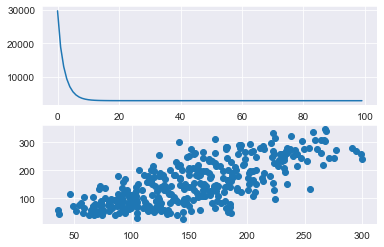

Parameter containing:
tensor([[  1.9400, -11.4488,  26.3047,  16.6306,  -9.8810,  -2.3179,  -7.6995,
           8.2121,  21.9769,   2.6065, 153.7365]])
Minimum cost: 2890.406494140625


In [18]:
cost_lst = list()
model = LinearRegression(x_train.shape[1])
alpha = .1
for it in range(100):
    prediction = model(x_train)
    cost = mean_squared_error(y_train, prediction)
    cost_lst.append(cost)
    gradient_descent_step(model, x_train, y_train, prediction, alpha)
fig, axs = plt.subplots(2)
axs[0].plot(list(range(it+1)), cost_lst)
axs[1].scatter(prediction, y_train)
plt.show()
print(model.weight)
print('Minimum cost: {}'.format(min(cost_lst)))

<font color="maroon">**Q5.** What conclusion if any can be drawn from the weight values? How does gender and BMI affect blood sugar levels?

What are the estimated blood sugar levels for the below examples? [2 marks] </font>

| AGE | SEX | BMI | BP  | S1  | S2    | S3 | S4  | S5     | S6  |
|-----|-----|-----|-----|-----|-------|----|-----|--------|-----|
| 25  | F   | 18  | 79  | 130 | 64.8  | 61 | 2   | 4.1897 | 68  |
| 50  | M   | 28  | 103 | 229 | 162.2 | 60 | 4.5 | 6.107  | 124 |

**Ans**
There are 11 values in the weight matrix, each corresponding to a single feature in the training dataset in addition with bias term. These values are coefficients of their respective feature and determines how and how much they relate with the target variable. Positive values show directly proportional relation while negative values show inverse relation. The scale of these values shows the strength of interdependence while their sign shows direction (as discussed above).
* Gender has a respective weight value of -11.448 which signifies that change in a single value of blood sugar level is affected by 11 times the value of gender in an inversely proportional way. 
* And for BMI, it has a respective weight value of 26.304 which signifies that change in a single value of blood sugar level is affected by 26 times the value of BMI in a directly proportional way.


In [19]:
examples = torch.Tensor([[25, 2, 18, 79, 130, 64.8, 61, 2, 4.1897, 68],
                                 [50, 1, 28, 103, 229, 162.2, 60, 4.5, 6.107, 124]])
examples = (examples - mu_x_train)/std_x_train
examples

tensor([[-1.8749,  1.0599, -1.9463, -1.1358, -1.6913, -1.6477,  0.8984, -1.6064,
         -0.8863, -2.0305],
        [ 0.0851, -0.9408,  0.3336,  0.5690,  1.1594,  1.5541,  0.8202,  0.3240,
          2.7678,  2.7640]])

In [20]:
examples = torch.hstack((examples, torch.ones((2,1))))

In [21]:
examples.shape

torch.Size([2, 11])

In [22]:
prediction = model(examples)

In [23]:
prediction

tensor([[ 43.5294],
        [232.2309]])

Now estimate the error on the test set. Is the error on the test set comparable to that of the train set? What can be said about the fit of the model? When does a model over/under fits?


In [24]:
prediction = model(x_test)
test_error = mean_squared_error(y_test, prediction)
print("Test Error: ",test_error)
print("Train Error: ", min(cost_lst))

Test Error:  tensor(2929.9829)
Train Error:  tensor(2890.4065)


<font color="maroon">**Q6.** Try the code with a number of learning rates that differ by orders of magnitude and record the error of the training and test sets. What do you observe on the training error? What about the error on the test set? [3 marks]</font>

**Ans**
The slope of the training error curve significantely changes to more uniform in nature rather than a sudden drop in the loss value and then staying dead (no optimization) for the rest of the iterations. Reducing the learning rate as the name suggests also slows down the process of learning the cost function optimially as the weights are learned with much smaller step. It might require more number of iterations as we move lower on the scale of learning rate to optimize the function because smaller steps would require 10s of times of more iterative step to minimize the error distance than the higher learning rates.

The Test error calculated on the test set by the model is very similar (close values, small distance with repective to the scale of the values) to the error on train set. This shows that the model is not overfitting on the training dataset and instead learning a generalized mapping of features to labels.

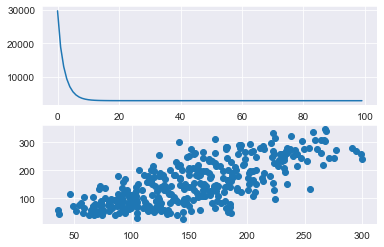

Minimum cost at alpha==0.1: 2890.406494140625


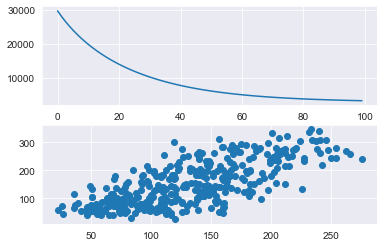

Minimum cost at alpha==0.01: 3356.778076171875


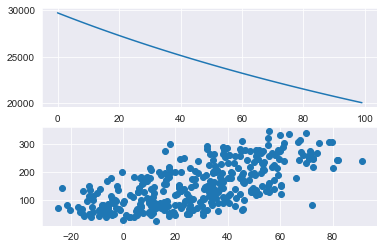

Minimum cost at alpha==0.001: 20040.58203125


In [25]:
error_rates = dict()
for alpha in [0.1,0.01,0.001]:
    cost_lst = list()
    model = LinearRegression(x_train.shape[1])
    for it in range(100):
        prediction = model(x_train)
        cost = mean_squared_error(y_train, prediction)
        cost_lst.append(cost)
        gradient_descent_step(model, x_train, y_train, prediction, alpha)
    fig, axs = plt.subplots(2)
    axs[0].plot(list(range(it+1)), cost_lst)
    axs[1].scatter(prediction, y_train)
    plt.show()
    prediction = model(x_test)
    test_error = mean_squared_error(y_test, prediction)
    error_rates[str(alpha)] = {"train error": cost, "test error": test_error}
    print('Minimum cost at alpha=={}: {}'.format(alpha, min(cost_lst)))

In [26]:
error_rates

{'0.1': {'train error': tensor(2890.4065), 'test error': tensor(2929.9829)},
 '0.01': {'train error': tensor(3356.7781), 'test error': tensor(3005.3503)},
 '0.001': {'train error': tensor(20040.5820),
  'test error': tensor(17473.3184)}}

# 1.2 Regularized Linear Regression
In this exercise, we will be trying to create a model that fits data that is clearly not linear. We will be attempting to fit the data points seen in the graph below:

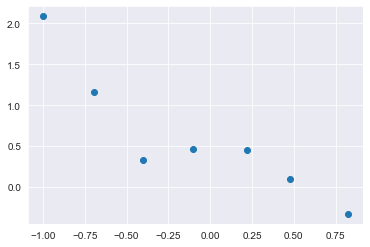

In [27]:
x = torch.tensor([-0.99768, -0.69574, -0.40373, -0.10236, 0.22024, 0.47742, 0.82229])
y = torch.tensor([2.0885, 1.1646, 0.3287, 0.46013, 0.44808, 0.10013, -0.32952]).reshape(-1, 1)
plt.scatter(x, y)
plt.show()

In order to fit this data we will create a new hypothesis function, which uses a fifth-order polynomial:

$
 h_{\theta}(x) = \theta_{0} x_{0} + \theta_{1} x_{1} + \theta_{2} x_{1} ^2 + \theta_{3} x_{1} ^3 + \theta_{4} x_{1} ^4 + \theta_{5} x_{1} ^5
$

As we are fitting a small number of points with a high order model, there is a danger of overfitting.  \\

To attempt to avoid this we will use regularization. Our cost function becomes:

$
 J(\theta) = \frac{1}{2m}  \left[ \sum_{i=1}^m ( h_{\theta}(x^{(i)}) - y^{(i)})^2 + \lambda    \sum_{j=1}^n \theta_{j}^2 \right] 
$

Adjust variable `x` to include the higher order polynomials

In [33]:
x3 = torch.stack([x, x**2, x**3, x**4, x**5, torch.ones(x.shape)]).T

In [34]:
print(x3)
x3.shape

tensor([[-9.9768e-01,  9.9537e-01, -9.9306e-01,  9.9075e-01, -9.8845e-01,
          1.0000e+00],
        [-6.9574e-01,  4.8405e-01, -3.3678e-01,  2.3431e-01, -1.6302e-01,
          1.0000e+00],
        [-4.0373e-01,  1.6300e-01, -6.5807e-02,  2.6568e-02, -1.0726e-02,
          1.0000e+00],
        [-1.0236e-01,  1.0478e-02, -1.0725e-03,  1.0978e-04, -1.1237e-05,
          1.0000e+00],
        [ 2.2024e-01,  4.8506e-02,  1.0683e-02,  2.3528e-03,  5.1818e-04,
          1.0000e+00],
        [ 4.7742e-01,  2.2793e-01,  1.0882e-01,  5.1952e-02,  2.4803e-02,
          1.0000e+00],
        [ 8.2229e-01,  6.7616e-01,  5.5600e-01,  4.5719e-01,  3.7595e-01,
          1.0000e+00]])


torch.Size([7, 6])

**Q7.** Update the cost and gradient descent methods to use the regularised cost, as shown above. [4 marks]

Note that the punishment for having more terms is not applied to the bias. This means that we use a different update technique for the partial derivative of $\theta_{0}$, and add the regularization to all of the others:



$
 \theta_{j} =  \theta_{j} - \alpha \frac{1}{m} \sum_{i=1}^m ( h_{\theta}(x^{(i)}) - y^{(i)})x^{(i)}_{j} , j=0 
$



$
 \theta_{j} =  \theta_{j} (1 - \alpha \frac{\lambda}{m}) - 
 \alpha \frac{1}{m} \sum_{i=1}^m ( h_{\theta}(x^{(i)}) - y^{(i)})x^{(i)}_{j} , j>0 
$

In [35]:
def mean_squared_error(y_true: torch.Tensor, y_pred: torch.Tensor, lam: float, theta: torch.tensor) -> torch.Tensor:
    cost = 0.5*(torch.mean((y_pred - y_true)**2) + lam*torch.mean(theta**2))
    return cost

def gradient_descent_step(model: nn.Module, X: torch.Tensor, y: torch.Tensor, y_pred: torch.Tensor, lr: float, lam:float) -> None:
    weight = model.weight
    N = X.shape[0]
    for x in range(6):
        if x == 5:
            weight[0,x] = weight[0,x] - lr*torch.mean((y_pred - y)*X[:,x])
        else:
            weight[0,x] = weight[0,x]*(1-(lr*lam/N)) - lr*torch.mean((y_pred - y)*X[:,x])
    model.weight = nn.Parameter(weight, requires_grad=False)

<font color="maroon"> **Q8.** First of all, find the best value of alpha to use in order to optimize best.
Next, experiment with different values of $\lambda$ and see how this affects the shape of the hypothesis. [3 marks]</font>

**Ans**
 I did the experimentation with different alpha rates like [0.5, 0.1, 0.05, 0.04, 0.03, 0.01] and found that 0.03 as the alpha gives me the satisfactory result with relatively smoother error minimization as well as no scope of further training with the flat/dead line for the last 20-30 iterations. 

After selecting the learning rate, I experimented for the value of regularizer (lambda) to observe the change in behavior of the hypothesis, learning curve and training error value. Just as we expected, lambda is applying restriction on the cost function to prevent overfitting the data, hence the training error value is increasing with each increasing lambda value but the shape of the hypothesis is barely changing. 

This pattern disrupted while we are increasing the lambda value to a relatively large number like ‘5’, such a value disturbed the learning curve with significant increase in error after certain iterations (20-25 iterations) of optimizing the weight for minimum cost. Setting the lambda value so high is causing unwanted increase in the importance of regularization rather than on the mean squared distance between the predicted values and ground truth values, which we meant to minimize to fit the hypothesis to our data. The shape of the hypothesis flattens out as a line rather than following the nature of exponential features in our training values.


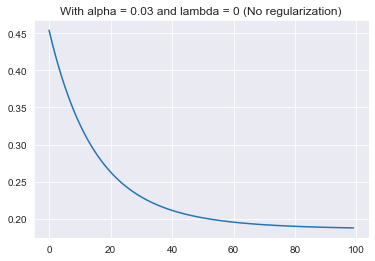

Parameter containing:
tensor([[-0.0468,  0.1794, -0.0497,  0.1214, -0.0524,  0.4820]])
Minimum cost: 0.1875617653131485


In [36]:
cost_lst = list()
model = LinearRegression(x3.shape[1])

alpha = 0.03 # select an appropriate alpha
lam = 0 # select an appropriate lambda
for it in range(100):
    prediction = model(x3)
    cost = mean_squared_error(y, prediction, lam, model.weight)
    cost_lst.append(cost)
    gradient_descent_step(model, x3, y, prediction, alpha, lam)
display.clear_output(wait=True)
plt.plot(list(range(it+1)), cost_lst)
plt.title("With alpha = 0.03 and lambda = 0 (No regularization)")
plt.show()
print(model.weight)
print('Minimum cost: {}'.format(min(cost_lst)))

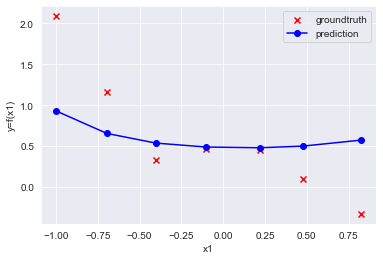

In [37]:
plt.scatter(x3[:, 0], y, c='red', marker='x', label='groundtruth')
outputs = model(x3)
plt.plot(x3[:, 0], outputs, c='blue', marker='o', label='prediction')
plt.xlabel('x1')
plt.ylabel('y=f(x1)')
plt.legend()
plt.show()

---

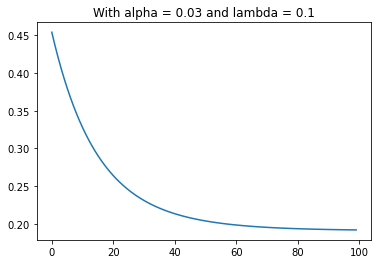

Parameter containing:
tensor([[-0.0455,  0.1744, -0.0483,  0.1180, -0.0509,  0.4839]])
Minimum cost: 0.19189567863941193


In [35]:
cost_lst = list()
model = LinearRegression(x3.shape[1])

alpha = 0.03 # select an appropriate alpha
lam = 0.1 # select an appropriate lambda
for it in range(100):
    prediction = model(x3)
    cost = mean_squared_error(y, prediction, lam, model.weight)
    cost_lst.append(cost)
    gradient_descent_step(model, x3, y, prediction, alpha, lam)
display.clear_output(wait=True)
plt.plot(list(range(it+1)), cost_lst)
plt.title("With alpha = 0.03 and lambda = 0.1")
plt.show()
print(model.weight)
print('Minimum cost: {}'.format(min(cost_lst)))


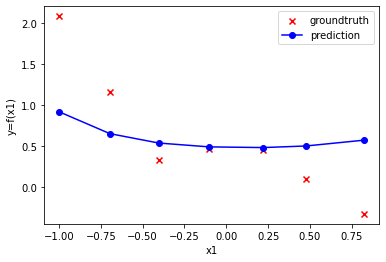

In [36]:
plt.scatter(x3[:, 0], y, c='red', marker='x', label='groundtruth')
outputs = model(x3)
plt.plot(x3[:, 0], outputs, c='blue', marker='o', label='prediction')
plt.xlabel('x1')
plt.ylabel('y=f(x1)')
plt.legend()
plt.show()

---

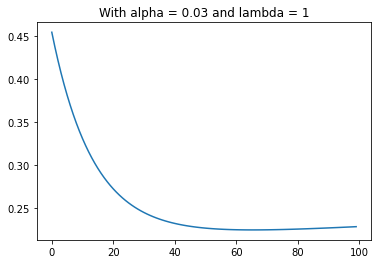

Parameter containing:
tensor([[-0.0355,  0.1361, -0.0377,  0.0921, -0.0397,  0.4995]])
Minimum cost: 0.2248290628194809


In [37]:
cost_lst = list()
model = LinearRegression(x3.shape[1])

alpha = 0.03 # select an appropriate alpha
lam = 1 # select an appropriate lambda
for it in range(100):
    prediction = model(x3)
    cost = mean_squared_error(y, prediction, lam, model.weight)
    cost_lst.append(cost)
    gradient_descent_step(model, x3, y, prediction, alpha, lam)
display.clear_output(wait=True)
plt.plot(list(range(it+1)), cost_lst)
plt.title("With alpha = 0.03 and lambda = 1")
plt.show()
print(model.weight)
print('Minimum cost: {}'.format(min(cost_lst)))

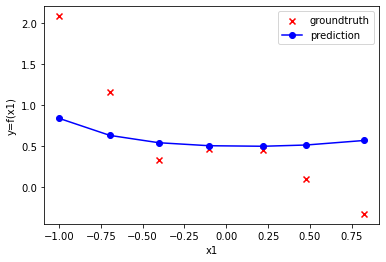

In [38]:
plt.scatter(x3[:, 0], y, c='red', marker='x', label='groundtruth')
outputs = model(x3)
plt.plot(x3[:, 0], outputs, c='blue', marker='o', label='prediction')
plt.xlabel('x1')
plt.ylabel('y=f(x1)')
plt.legend()
plt.show()

---

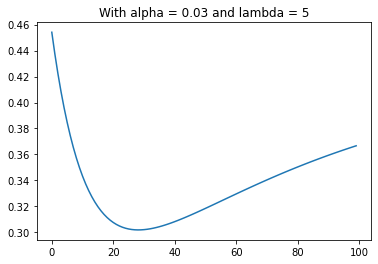

Parameter containing:
tensor([[-0.0132,  0.0506, -0.0140,  0.0342, -0.0148,  0.5395]])
Minimum cost: 0.3019304573535919


In [39]:
cost_lst = list()
model = LinearRegression(x3.shape[1])

alpha = 0.03 # select an appropriate alpha
lam = 5 # select an appropriate lambda
for it in range(100):
    prediction = model(x3)
    cost = mean_squared_error(y, prediction, lam, model.weight)
    cost_lst.append(cost)
    gradient_descent_step(model, x3, y, prediction, alpha, lam)
display.clear_output(wait=True)
plt.plot(list(range(it+1)), cost_lst)
plt.title("With alpha = 0.03 and lambda = 5")
plt.show()
print(model.weight)
print('Minimum cost: {}'.format(min(cost_lst)))

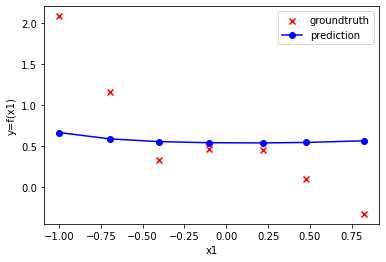

In [40]:
plt.scatter(x3[:, 0], y, c='red', marker='x', label='groundtruth')
outputs = model(x3)
plt.plot(x3[:, 0], outputs, c='blue', marker='o', label='prediction')
plt.xlabel('x1')
plt.ylabel('y=f(x1)')
plt.legend()
plt.show()

---